# 生成模拟数据

In [10]:
import os
path = '/project'
txt_file_name = os.path.join(path,'data','alpha_words.txt')
fonts_path = os.path.join(path,'data' ,'fonts_hw_char')
output_path = os.path.join(path,'data','images')
b_image_path = os.path.join(path,'data', 'background')
img_height = 32
img_width = 100
total_number = 500000
image_number = 500000
# alpha = 'ABCDEFGHIJKLMN'
alpha = 'ABCDEFGH'
# noise_alpha = '•■●'
thread_pre=11
need_dilate=False
noise_alpha = ')(.■●'
# alpha = '0123456789+-÷×=)(＋－（）＝'
# alpha = '0123456789.'
# alpha = '√×'
# alpha = 'DI'

In [12]:
# 生成字符
import lib.gen_image as gen
import importlib
importlib.reload(gen)

gen.gen_words(txt_file_name, alpha,min_number=1, max_number=3, total=total_number,noise_alpha=noise_alpha)
print('over')


over


In [13]:
# 生成训练图片
import lib.gen_image as gen
import os
import numpy as np
import random
import importlib
import shutil
import cv2
import lib.image_utils as img_utils
import json
importlib.reload(gen)
importlib.reload(img_utils)

# 清空目录
shutil.rmtree(output_path)  
os.mkdir(output_path) 

# 字体
all_fonts = []
all_fonts_name = []
for root, dirs, files in os.walk(fonts_path):
    for file in files:
        if file.endswith(".ttf"):
            all_fonts.append(os.path.join(root, file))
            all_fonts_name.append(file[:-4])
            
with open(txt_file_name) as f:
    text_lines = f.readlines()
text_lines = [t.strip() for t in text_lines]
text_lines = [t for t in text_lines if len(t) > 0]

bg_file_lists = [os.path.join(b_image_path, x) for x in os.listdir(b_image_path)]
# print(bg_file_lists)

# font_size_list = [20,24,28,32,36,40]
font_size_list = [20,24,28,32,36,40,44]
number_of_examples = image_number



image_list = []
output_data =[]
print('begin ....')
for i, txt in enumerate(random.sample(text_lines, number_of_examples)):
    if i%50000 == 0:
        print(i)    
    select_font_idx = np.random.randint(len(all_fonts))
#     img_height, img_width, font_size_list = text_set[np.random.randint(len(text_set))]
    img_height = 32
    img_width = 100
    font_size = font_size_list[np.random.randint(len(font_size_list))]
    image = gen.make_image(test_str=txt, fonttype=all_fonts[select_font_idx], 
                         fontsize=font_size,target_width=img_width, target_height=img_height, 
                         back_ground_img_list=bg_file_lists, 
                         need_include=False,gray_type=True,thread_pre=thread_pre)
    if need_dilate:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        image = cv2.dilate(image, kernel, iterations=2)    

    #     print('image size -->', image.shape)
    img_path = os.path.join(output_path, str(i)+'_'+all_fonts_name[select_font_idx] + ".png")
#     image_list.append(image)
    cv2.imwrite(img_path, image)    
#     txt = txt.replace('＋','+')
#     txt = txt.replace('－','-')
#     txt = txt.replace('（','(')
#     txt = txt.replace('）',')')
#     txt = txt.replace('＝','=')
    txt = txt.replace('■','')
#     txt = txt.replace('•','')
    txt = txt.replace('●','')
    txt = txt.replace('(','')
    txt = txt.replace(')','')
    txt = txt.replace('.','')
#     print('txt -->', txt)
    output_data.append({
        "image_path": "{}_{}.png".format(str(i), all_fonts_name[select_font_idx]),
        "gt": txt.lower()
    })    
            
# 增加手工生成数据
check_path = os.path.join(path,'data', 'test','char')
crop_out_path = os.path.join(path,'data','train','char')
check_files = []
for root, dirs, files in os.walk(check_path):
    for file in files:
        if file.endswith(".png"):
            check_files.append(os.path.join(root, file))

custom_number_of_examples = int(number_of_examples * 10e-5)
for idx, imgfile in enumerate(check_files):
#     print(imgfile)
    image = cv2.imread(imgfile, cv2.IMREAD_COLOR)
#     print(image.shape)
    source_image = image.copy()
#     number = int(imgfile[imgfile.index('_') + 1:imgfile.index('.png')])
    number = 1
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    if number >= 10000:
        ret, image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV)
        if need_dilate:
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
            image = cv2.dilate(image, kernel, iterations=2)            
    else:
        x1,y1,x2,y2 = img_utils.detect_char_area(image_gray.copy(),min_area=10,min_y_diff=5)
        image = image_gray[y1:y2,x1:x2]
        image = img_utils.convert_img_bin(image,thread_pre=thread_pre,need_dilate=need_dilate)
    
    if image is not None:
        percent = float(32) / image.shape[0]
        image = cv2.resize(image,(0,0), fx=percent, fy=percent, interpolation = cv2.INTER_AREA)
        crop_imgfile = imgfile.replace('test','train')
        cv2.imwrite(crop_imgfile,image)
        txt = imgfile[imgfile.index('char')+5:imgfile.index('_')]
        if 'char' in txt:
            raise Exception('error txt --> {}'.format(imgfile))
        for _ in range(custom_number_of_examples):
            number_of_examples = number_of_examples + 1
            output_data.append({
                "image_path": crop_imgfile,
                "gt": txt.lower()
            })    
    


        
train_cnt = int(number_of_examples  * 1.0)
val_cnt = number_of_examples - train_cnt
with open(os.path.join(path,'data', 'training.json'), 'w') as f:
    json.dump(output_data[:train_cnt], f)

with open(os.path.join(path,'data', 'validation.json'), 'w') as f:
    json.dump(output_data[train_cnt:], f)

print('over -->', number_of_examples)


begin ....
0
50000
100000
150000
200000
250000
300000
350000
400000
450000


/project/code/lib/image_utils.py:70: RuntimeWarning: overflow encountered in ubyte_scalars
  areas_filter_idx = np.where(abs(areas_cents - cent_y) < min_y_diff)
/project/code/lib/image_utils.py:71: RuntimeWarning: overflow encountered in ubyte_scalars
  #     print('areas_filter_idx -->{}'.format(areas_filter_idx))


over --> 1205700


['490788_Pacifico-Regular.png', '305054_Pacifico-Regular.png', '196931_Hyfyfy.png', '214305_GloriaHallelujah.png', '209183_simple.png', '107287_Satisfy-Regular.png', '195304_Exo-Regular.png', '165766_Lato-Regular.png', '176725_GloriaHallelujah.png', '181240_simple.png']


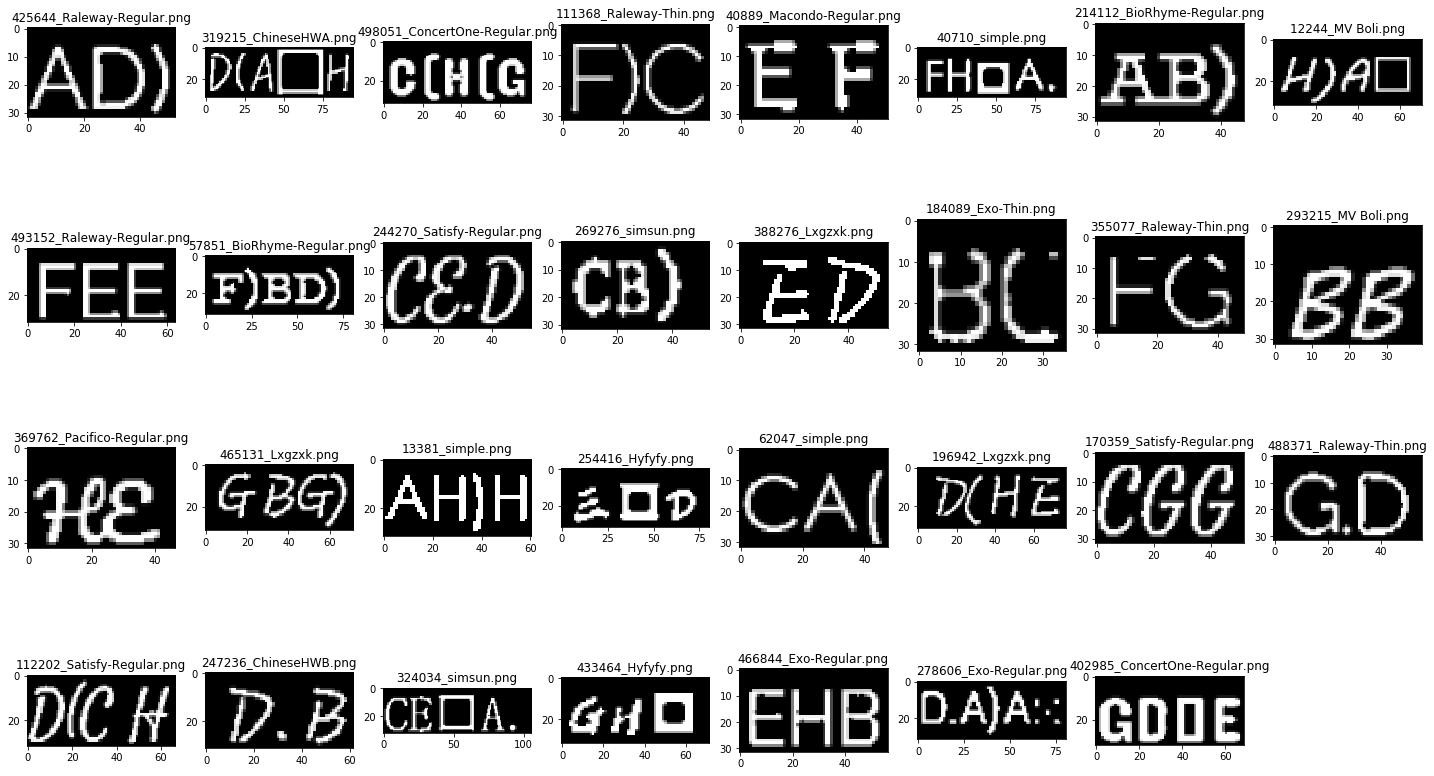

In [14]:
# 显示生成的图片
import torch
from PIL import Image
from torch.autograd import Variable
import lib.dataset as dataset
import importlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import lib.utils as utils
import os
plt.rcParams['figure.figsize'] = 25, 15


images_path = os.path.join(path,'data', 'images')
images_files = []
images_files_name = []
for root, dirs, files in os.walk(images_path):
    for file in files:
        images_files.append(os.path.join(root,file ))
        images_files_name.append(file)
print(images_files_name[0:10])

plt.figure()
for i in range(1,32):
    select_number = np.random.randint(image_number)
#     image = Image.open(images_files[select_number])
    image = cv2.imread(images_files[select_number], cv2.IMREAD_GRAYSCALE)
#     print(image.shape)
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     blur = cv2.GaussianBlur(gray, (3,3), 0)
#     thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,15,10)
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
#     dilate = cv2.dilate(thresh, kernel, iterations=1)
#     erode = cv2.erode(dilate, kernel, iterations=1)
    
#     image = cv2.bitwise_not(thresh)
    
    plt.subplot(4,8,i)
    plt.title(images_files_name[select_number])
    plt.imshow(image,'gray')
# plt.imshow(image,'brg')
plt.show()

In [15]:
# 生成训练库
import json
from lib.gen_dataset import createDataset
import os
img_path = os.path.join(path,'data','images')
train_file = os.path.join(path, 'data','training.json') 
valid_file = os.path.join(path, 'data','validation.json') 
with open(train_file,'r') as f:
    train_data = json.load(f)
    
imgLabelLists = []
for item in train_data:
    imgLabelLists.append((os.path.join(path,'data','images',item['image_path']) ,str(item['gt'])))

random.shuffle(imgLabelLists)
train_lmdb_path = os.path.join(path,'data','lmdb')   # 训练数据
trainImgPaths = [x[0] for x in imgLabelLists]
trainTxtLists = [x[1] for x in imgLabelLists]
createDataset(train_lmdb_path, trainImgPaths, trainTxtLists, lexiconList=None, checkValid=True)
    

samples length -- > 1205700
Written 50000 / 1205700
Written 100000 / 1205700
Written 150000 / 1205700
Written 200000 / 1205700
Written 250000 / 1205700
Written 300000 / 1205700
Written 350000 / 1205700
Written 400000 / 1205700
Written 450000 / 1205700
Written 500000 / 1205700
Written 550000 / 1205700
Written 600000 / 1205700
Written 650000 / 1205700
Written 700000 / 1205700
Written 750000 / 1205700
Written 800000 / 1205700
Written 850000 / 1205700
Written 900000 / 1205700
Written 950000 / 1205700
Written 1000000 / 1205700
Written 1050000 / 1205700
Written 1100000 / 1205700
Written 1150000 / 1205700
Written 1200000 / 1205700
Created dataset with 1205700 samples


In [17]:
# traindata loader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import lib.dataset as dataset
import lib.utils as utils
import time
import importlib
importlib.reload(dataset)
importlib.reload(utils)

batch_size = 100

train_dataset = dataset.lmdbDataset(root= os.path.join(path,'data','lmdb'))
# print('train data set length -->{}'.format(len(train_dataset)))
train_set, val_set = torch.utils.data.random_split(train_dataset,
                                                   [int(0.9*len(train_dataset)), 
                                                    int(0.1*len(train_dataset))])


train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size,
    shuffle=True,
    collate_fn=dataset.adjustCollate(imgH=32, keep_ratio=False))
#     

for step, values in enumerate(train_loader):
    images = Variable(values[0].type(torch.FloatTensor), requires_grad=False)
#     images = values[0]
    print('step -->', images.size(), '-->', len(images))
    break

print('over')


step --> torch.Size([90, 3, 32, 117]) --> 90
over


In [55]:
# image 统一长度
PADDING_CONSTANT = 255
assert len(set([b.shape[0] for b in image_list])) == 1
assert len(set([b.shape[2] for b in image_list])) == 1

dim0 = image_list[0].shape[0]
dim1 = max([b.shape[1] for b in image_list])
dim2 = image_list[0].shape[2]

image_list_new = np.full((len(image_list), dim0, dim1, dim2), PADDING_CONSTANT).astype(np.long)
print(len(image_list_new))
for idx, image in enumerate(image_list_new):
    image[:,:image_list[idx].shape[1],:] = image_list[idx]
    img_path = os.path.join(output_path, str(idx)+'_'+all_fonts_name[idx%len(all_fonts)] + ".png")
    cv2.imwrite(img_path, image)   
    

100
